In [1]:
#!pip install prince

In [2]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
import matplotlib.patches as mpatches
import prince

## Data Cleanup

In [4]:
p = Path("LLCP2023.XPT")  # <- your current path
print("Exists?", p.exists(), "Size:", p.stat().st_size if p.exists() else "N/A")

# Peek at the first bytes: true SAS XPORT files start with ASCII text:
# b'HEADER RECORD*******LIBRARY HEADER RECORD'
if p.exists():
    with open(p, "rb") as f:
        sig = f.read(48)
    print("Signature:", sig)

# If it looks like an XPT (starts with b'HEADER RECORD'), rename to .XPT (drop the underscore).
if p.exists() and sig.startswith(b"HEADER RECORD"):
    newp = p.with_name("LLCP2023.XPT")
    p.rename(newp)
    print("Renamed to", newp)


Exists? True Size: 1205554400
Signature: b'HEADER RECORD*******LIBRARY HEADER RECORD!!!!!!!'
Renamed to LLCP2023.XPT


In [5]:
# If you now have LLCP2023.XPT (no underscore):
df = pd.read_sas("LLCP2023.XPT", format="xport", encoding="latin1")
print(df.shape)
print(df.head(3))


(433323, 350)
   _STATE  FMONTH     IDATE IMONTH IDAY IYEAR  DISPCODE       SEQNO  \
0     1.0     1.0  03012023     03   01  2023    1100.0  2023000001   
1     1.0     1.0  01062023     01   06  2023    1100.0  2023000002   
2     1.0     1.0  03082023     03   08  2023    1100.0  2023000003   

           _PSU  CTELENM1  ...      DROCDY4_  _RFBING6      _DRNKWK2  \
0  2.023000e+09       1.0  ...  5.397605e-79       1.0  5.397605e-79   
1  2.023000e+09       1.0  ...  5.397605e-79       1.0  5.397605e-79   
2  2.023000e+09       1.0  ...  5.397605e-79       1.0  5.397605e-79   

   _RFDRHV8  _FLSHOT7  _PNEUMO3  _AIDTST4  _RFSEAT2  _RFSEAT3  _DRNKDRV  
0       1.0       2.0       2.0       2.0       1.0       1.0       9.0  
1       1.0       1.0       1.0       2.0       1.0       1.0       9.0  
2       1.0       1.0       1.0       2.0       1.0       1.0       9.0  

[3 rows x 350 columns]


In [6]:
#pd.set_option("display.max_rows", None)
#pd.DataFrame({"idx": range(len(df.columns)), "name": df.columns})


In [7]:
# Columns grouped by type
outcome_vars = ["_RFHLTH"]
pa_vars = ["_TOTINDA"]
ses_vars = ["EDUCA", "_INCOMG1", "EMPLOY1", "_HLTHPL1",
            "PERSDOC3", "MEDCOST1", "MARITAL", "CHILDREN"]
demo_vars = ["_SEX", "_IMPRACE", "_BMI5CAT", "_AGE_G"]


all_keep = outcome_vars + pa_vars + ses_vars + demo_vars
df_mini = df[all_keep].copy()

In [8]:
df_mini.columns = df_mini.columns.to_series().replace({"_RFHLTH": "Health", "_TOTINDA": "Exercise", "EDUCA":"Education",
                       "_INCOMG1": "Income", "EMPLOY1": "Employment", "_HLTHPL1": "Insurance",
                       "PERSDOC3": "PCP", "MEDCOST1": "MEDCOST", "_AGE_G": "Age", "_SEX": "Sex",
                       "_IMPRACE": "Race", "_BMI5CAT": "BMI"})

In [9]:
# 3) Show as a small table (easy to filter/sort)
pd.set_option("display.max_rows", None)
pd.DataFrame({"idx": range(len(df_mini.columns)), "name": df_mini.columns})

,idx,name
0,0,Health
1,1,Exercise
2,2,Education
3,3,Income
4,4,Employment
5,5,Insurance
6,6,PCP
7,7,MEDCOST
8,8,MARITAL
9,9,CHILDREN


In [10]:
df_mini['Health'].value_counts()

Health
1.0    349734
2.0     82327
9.0      1262
Name: count, dtype: int64

In [11]:
df_mini['CHILDREN'] = df_mini['CHILDREN'].replace(88.0, 0)
df_mini = df_mini[df_mini['CHILDREN'] <= 8]
df_mini = df_mini[df_mini['Income'] != 9]
df_mini = df_mini[df_mini['Health'] !=9]
df_mca = df_mini
df_mca = df_mca.dropna(subset=['BMI'])
df_mca = df_mca.dropna(subset=['PCP'])

In [12]:
# Define mapping
employ_map = {
    1: 1,  #Employed 
    2: 1, 
    3: 0,  # Unemployed
    4: 0,  
    5: 0,  
    6: 0,
    7: 0,  
    8: 0,  
    9: 0
}
# Define mapping
PCP_map = {
    1: 1,  #does have primary care physician
    2: 1,  
    3: 0, #doesnt have pcp
    7: 0,  
    9: 0
}
sex_map = {
    1:1, #male
    2:0 #female
}
health_map = {
    1:1, #good heatlh
    2:0, #bad health
}

marital_map = {
    1:1, #married
    2:0,#not married
    3:0,
    4:0,
    5:0,
    6:0,
    9:0
}
med_map = {
    1:1,#couldnt afford dr visit
    2:0,#could afford dr visit
    7:0,
    9:0
}
df_mini['Employment'] = df_mini['Employment'].map(employ_map)
df_mini['PCP'] = df_mini['PCP'].map(PCP_map)
df_mini['Sex'] = df_mini['Sex'].map(sex_map)
df_mini['MARITAL'] = df_mini['MARITAL'].map(marital_map)
df_mini['MEDCOST'] = df_mini['MEDCOST'].map(med_map)
df_mini['Health'] = df_mini['Health'].map(sex_map)




In [13]:
df_mini = df_mini.dropna(subset=['BMI'])
df_mini = df_mini.dropna(subset=['PCP'])

In [14]:
df_mini.head()

,Health,Exercise,Education,Income,Employment,Insurance,PCP,MEDCOST,MARITAL,CHILDREN,Sex,Race,BMI,Age
2,0,1.0,4.0,1.0,0,1.0,1.0,1,0,0.0,0,2.0,2.0,6.0
4,0,1.0,5.0,5.0,0,1.0,1.0,0,0,0.0,0,1.0,3.0,6.0
5,1,1.0,5.0,5.0,0,1.0,1.0,0,0,0.0,0,2.0,4.0,5.0
6,0,2.0,4.0,4.0,0,1.0,1.0,0,0,0.0,1,1.0,2.0,6.0
8,1,2.0,5.0,4.0,0,1.0,1.0,0,0,0.0,0,2.0,4.0,6.0


In [15]:
df_mini['MEDCOST'].value_counts()

MEDCOST
0    299548
1     27838
Name: count, dtype: int64

## MCA and Exploratory Data Analysis

In [17]:
# Split dependent and independent variables
X = df_mini.iloc[:, 1:]   # independent categorical variables
y = df_mini.iloc[:, 0]    # dependent binary variable

# One-hot encode categorical variables
encoder = OneHotEncoder(drop='first', sparse_output=False)
X_encoded = encoder.fit_transform(X)

# Create a DataFrame for encoded features
encoded_cols = encoder.get_feature_names_out(X.columns)
X_encoded_df = pd.DataFrame(X_encoded, columns=encoded_cols)

# Fit logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_encoded_df, y)

# Get feature importances (absolute value of coefficients)
importances = abs(model.coef_[0])
feature_importance = pd.Series(importances, index=encoded_cols).sort_values(ascending=False)

#print(feature_importance)


In [18]:
df_encoded = pd.concat([y.reset_index(drop=True), X_encoded_df], axis=1)
df_encoded.shape

(327386, 43)

In [19]:
df_encoded.head()

,Health,Exercise_2.0,Exercise_9.0,Education_2.0,Education_3.0,Education_4.0,Education_5.0,Education_6.0,Education_9.0,Income_2.0,...,Race_5.0,Race_6.0,BMI_2.0,BMI_3.0,BMI_4.0,Age_2.0,Age_3.0,Age_4.0,Age_5.0,Age_6.0
0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [20]:
#mca.eigenvalues_summary


In [21]:
#mca.column_coordinates(df_mini)

In [22]:
print(df_encoded.shape)
print(df_encoded.columns)
print(df_encoded.dtypes.head())

(327386, 43)
Index(['Health', 'Exercise_2.0', 'Exercise_9.0', 'Education_2.0',
       'Education_3.0', 'Education_4.0', 'Education_5.0', 'Education_6.0',
       'Education_9.0', 'Income_2.0', 'Income_3.0', 'Income_4.0', 'Income_5.0',
       'Income_6.0', 'Income_7.0', 'Employment_1', 'Insurance_2.0',
       'Insurance_9.0', 'PCP_1.0', 'MEDCOST_1', 'MARITAL_1', 'CHILDREN_1.0',
       'CHILDREN_2.0', 'CHILDREN_3.0', 'CHILDREN_4.0', 'CHILDREN_5.0',
       'CHILDREN_6.0', 'CHILDREN_7.0', 'CHILDREN_8.0', 'Sex_1', 'Race_2.0',
       'Race_3.0', 'Race_4.0', 'Race_5.0', 'Race_6.0', 'BMI_2.0', 'BMI_3.0',
       'BMI_4.0', 'Age_2.0', 'Age_3.0', 'Age_4.0', 'Age_5.0', 'Age_6.0'],
      dtype='object')
Health             int64
Exercise_2.0     float64
Exercise_9.0     float64
Education_2.0    float64
Education_3.0    float64
dtype: object


In [23]:
#df_mca = df_mini
X = df_mca.drop(columns=['Health', 'Exercise', 'PCP', 'BMI', 'Age', 'MARITAL'])
X.head()

,Education,Income,Employment,Insurance,MEDCOST,CHILDREN,Sex,Race
2,4.0,1.0,7.0,1.0,1.0,0.0,2.0,2.0
4,5.0,5.0,8.0,1.0,2.0,0.0,2.0,1.0
5,5.0,5.0,7.0,1.0,2.0,0.0,2.0,2.0
6,4.0,4.0,8.0,1.0,2.0,0.0,1.0,1.0
8,5.0,4.0,7.0,1.0,2.0,0.0,2.0,2.0


In [24]:
X = df_mca.drop(columns=['Health'])
y = df_mca['Health']


In [25]:
mca = prince.MCA(
    n_components=2,      
    n_iter=3,
    copy=True,
    check_input=True,
    engine='sklearn',
    random_state=42,
    one_hot=False
)
mca = mca.fit(X)


In [26]:
X_mca = mca.transform(X)
print("MCA component space shape:", X_mca.shape)


MCA component space shape: (327386, 2)


In [27]:
print(mca.total_inertia_)
print( mca.percentage_of_variance_)
print( mca.cumulative_percentage_of_variance_)


0.2970482694452978
[29.06717054 17.61967379]
[29.06717054 46.68684433]


In [28]:
mca.eigenvalues_summary

,eigenvalue,% of variance,% of variance (cumulative)
component,,,
0,0.086,29.07%,29.07%
1,0.052,17.62%,46.69%


In [29]:
column_coords = mca.column_coordinates(X)
column_coords


,0,1
Exercise,-0.001762,-0.013848
Education,0.061383,0.020261
Income,0.155184,0.086239
Employment,-0.575085,0.186878
Insurance,0.083349,-0.215456
PCP,0.101012,-0.081912
MEDCOST,0.032621,0.013672
MARITAL,0.105372,-0.585401
CHILDREN,1.515322,0.993340
Sex,0.032329,0.010523


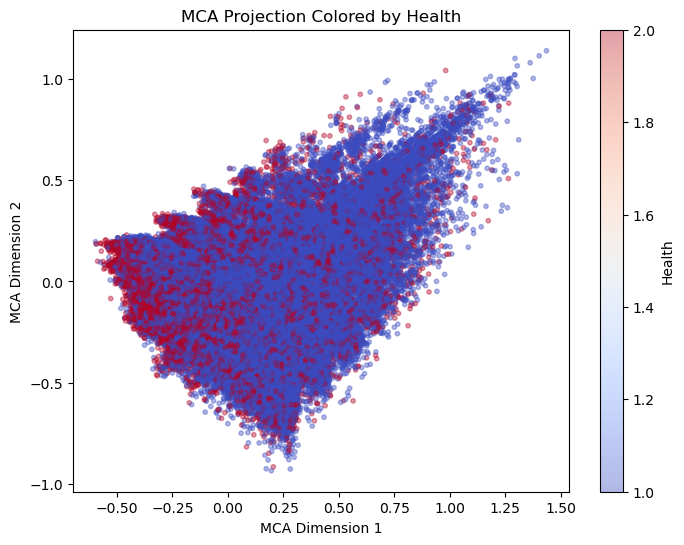

In [30]:
plt.figure(figsize=(8,6))
plt.scatter(
    X_mca[0], 
    X_mca[1], 
    c=y, 
    cmap='coolwarm', 
    alpha=0.4, 
    s=10
)
plt.xlabel("MCA Dimension 1")
plt.ylabel("MCA Dimension 2")
plt.title("MCA Projection Colored by Health")
plt.colorbar(label="Health")
plt.show()


In [55]:
coords = mca.transform(df_mca).copy()
coords.columns = ['Dim1','Dim2']  # for readability


In [57]:
import numpy as np

u = np.array([1.0, 1.0]) / np.sqrt(2)   # top-right direction
s_tr = coords[['Dim1','Dim2']].values @ u
tr_id = coords.index[s_tr.argmax()]

v = -u                                  # bottom-left direction
s_bl = coords[['Dim1','Dim2']].values @ v
bl_id = coords.index[s_bl.argmax()]


In [59]:
compare_cols = ["Education","Income","Employment","Insurance","MEDCOST","CHILDREN","Race","Sex","Age","Health"]  # adjust as you like

df_compare = df_mca.loc[[tr_id, bl_id], compare_cols].T
df_compare.columns = ['TopRight_individual','BottomLeft_individual']
print(df_compare)


            TopRight_individual  BottomLeft_individual
Education                   4.0                    4.0
Income                      1.0                    1.0
Employment                  1.0                    8.0
Insurance                   1.0                    1.0
MEDCOST                     2.0                    2.0
CHILDREN                    8.0                    0.0
Race                        1.0                    2.0
Sex                         1.0                    1.0
Age                         3.0                    5.0
Health                      1.0                    2.0


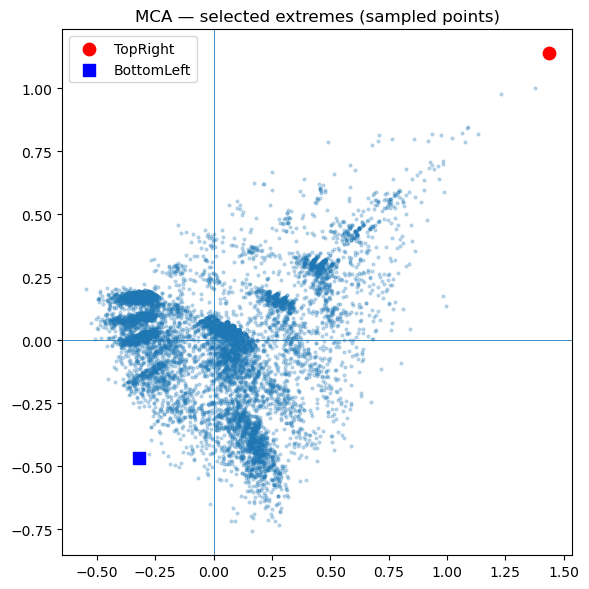

In [63]:
# Sample a fraction (adjust as needed)
sample_idx = coords.sample(10000, random_state=42).index

plt.figure(figsize=(6,6))
plt.scatter(coords.loc[sample_idx, 'Dim1'],
            coords.loc[sample_idx, 'Dim2'],
            s=4, alpha=0.25)

# highlight extremes
plt.scatter(coords.loc[tr_id,'Dim1'], coords.loc[tr_id,'Dim2'], 
            s=80, marker='o', color='red', label='TopRight')
plt.scatter(coords.loc[bl_id,'Dim1'], coords.loc[bl_id,'Dim2'], 
            s=80, marker='s', color='blue', label='BottomLeft')

plt.axhline(0,lw=0.6); plt.axvline(0,lw=0.6)
plt.title("MCA — selected extremes (sampled points)")
plt.legend()
plt.tight_layout()
plt.show()


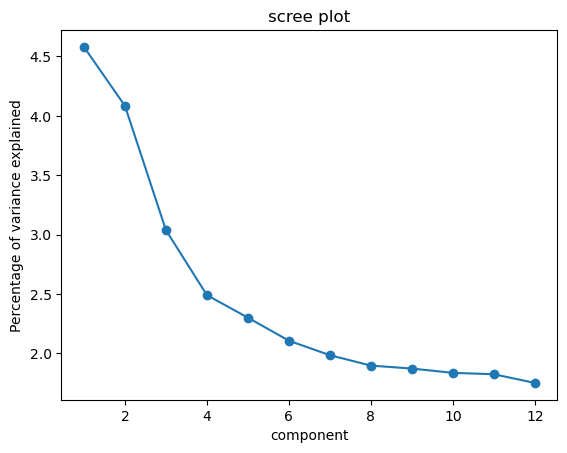

In [35]:
mca_full = prince.MCA(n_components=min(30, X.shape[1]-1), random_state=42)
mca_full = mca_full.fit(X)

inertia = mca_full.percentage_of_variance_

plt.plot(range(1, len(inertia)+1), inertia, marker='o')
plt.xlabel("component")
plt.ylabel("Percentage of variance explained")
plt.title("scree plot")
plt.show()


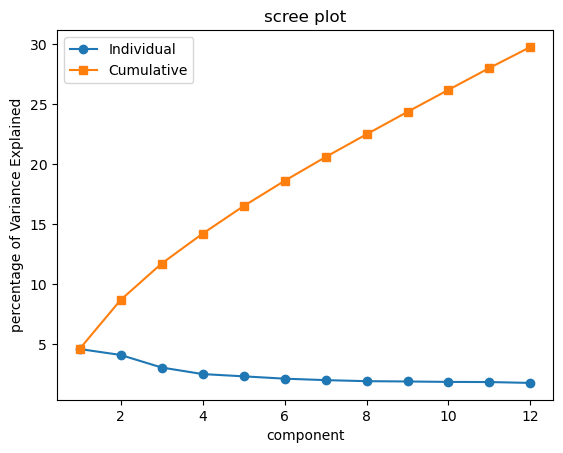

In [36]:
cum_inertia = mca_full.cumulative_percentage_of_variance_

plt.plot(range(1, len(inertia)+1), inertia, marker='o', label='Individual')
plt.plot(range(1, len(cum_inertia)+1), cum_inertia, marker='s', label='Cumulative')
plt.xlabel("component")
plt.ylabel("percentage of Variance Explained")
plt.title("scree plot")
plt.legend()
plt.show()

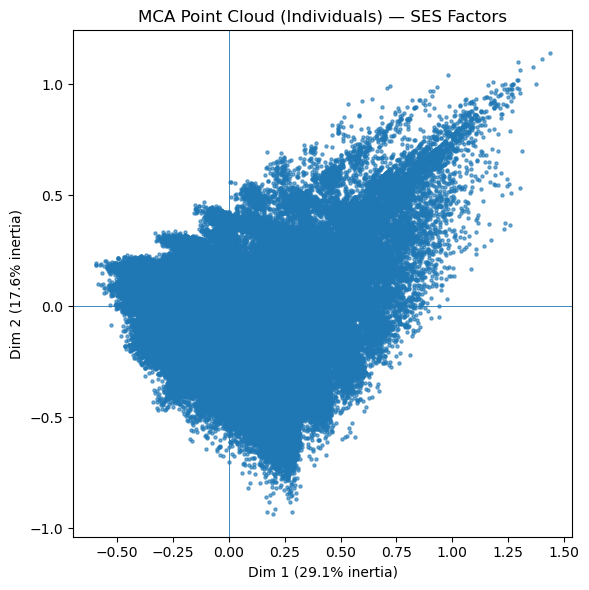

In [37]:

# 4) Get individual coordinates (rows) in MCA space
coords = mca.transform(df_mca)  # DataFrame with columns [0, 1] for Dim1, Dim2

dim1_pct = mca.percentage_of_variance_[0]
dim2_pct = mca.percentage_of_variance_[1]
# 6) Simple point cloud
plt.figure(figsize=(6,6))
plt.scatter(coords[0], coords[1], s=5, alpha=0.6)
plt.xlabel(f"Dim 1 ({dim1_pct:.1f}% inertia)")
plt.ylabel(f"Dim 2 ({dim2_pct:.1f}% inertia)")
plt.title("MCA Point Cloud (Individuals) — SES Factors")
plt.axhline(0, lw=0.6)
plt.axvline(0, lw=0.6)
plt.tight_layout()
plt.show()


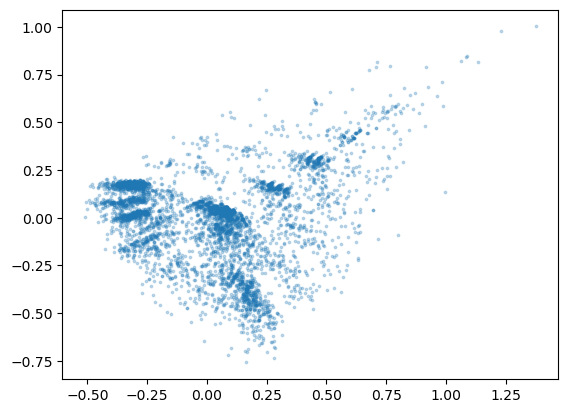

In [41]:
#YOOOO Guttman affect
ix = coords.sample(5000, random_state=42).index   # pick a size that renders cleanly
plt.scatter(coords.loc[ix,0], coords.loc[ix,1], s=3, alpha=0.25)

When overplotting was reduced, the MCA point cloud revealed a slight Guttman or “arch” effect, indicating that much of the variability among individuals follows a single socioeconomic gradient. This suggests that employment, family load, and related variables form an ordered continuum of socioeconomic status rather than multiple orthogonal dimensions. The curvature observed in the second axis likely reflects a nonlinear extension of the primary SES dimension rather than a distinct factor.

In [51]:
np.corrcoef(coords[0], coords[1])[0,1]


0.01354679765886132

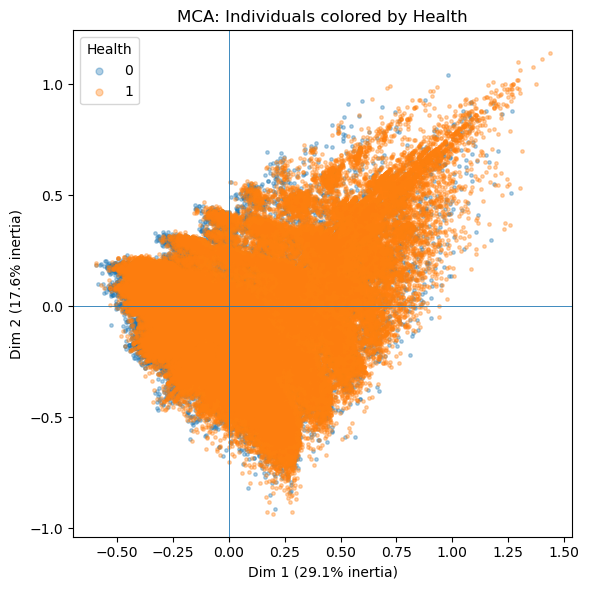

In [39]:
coords = mca.transform(df_mca)            # rows → MCA space
lab = df_mini['Health']                        # e.g., {'Poor','Fair','Good','Very good','Excellent'}

plt.figure(figsize=(6,6))
for g in lab.unique():
    idx = (lab==g)
    plt.scatter(coords.loc[idx, 0], coords.loc[idx, 1], s=6, alpha=0.35, label=str(g))
plt.legend(title="Health", markerscale=2)
plt.axhline(0, lw=0.6); plt.axvline(0, lw=0.6)
plt.xlabel(f"Dim 1 ({mca.percentage_of_variance_[0]:.1f}% inertia)")
plt.ylabel(f"Dim 2 ({mca.percentage_of_variance_[1]:.1f}% inertia)")
plt.title("MCA: Individuals colored by Health")
plt.tight_layout()

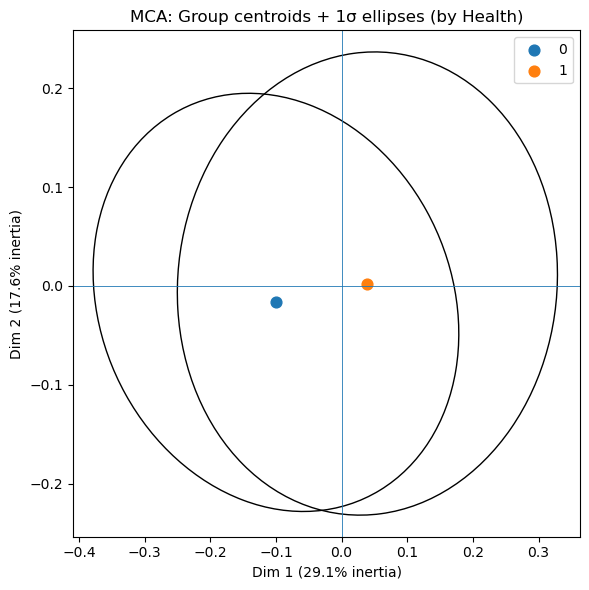

In [43]:
def plot_group_centroid_ellipse(points, ax, label):
    mu = points.mean(0).values
    S = np.cov(points.values.T)
    vals, vecs = np.linalg.eigh(S)
    order = vals.argsort()[::-1]
    vals, vecs = vals[order], vecs[:, order]
    width, height = 2*np.sqrt(vals)      # ~1σ ellipse
    angle = np.degrees(np.arctan2(*vecs[:,0][::-1]))
    e = mpatches.Ellipse(mu, width, height, angle=angle, fill=False, lw=1)
    ax.add_patch(e); ax.scatter(*mu, marker='o', s=60, label=label)

fig, ax = plt.subplots(figsize=(6,6))
for g in lab.unique():
    pts = coords.loc[lab==g, [0,1]]
    plot_group_centroid_ellipse(pts, ax, str(g))
ax.axhline(0, lw=0.6); ax.axvline(0, lw=0.6)
ax.set_xlabel(f"Dim 1 ({mca.percentage_of_variance_[0]:.1f}% inertia)")
ax.set_ylabel(f"Dim 2 ({mca.percentage_of_variance_[1]:.1f}% inertia)")
ax.set_title("MCA: Group centroids + 1σ ellipses (by Health)")
ax.legend()
plt.tight_layout()


In this MCA, the first dimension (32.8 % inertia) represents an employment-family-load gradient, while the second (19.9 % inertia) reflects marital and household structure. Individuals at opposite ends of these axes occupy markedly different socioeconomic positions—unemployed, younger adults with many dependents versus older, employed or married individuals with fewer dependents—explaining their separation in the MCA space.

In [45]:
print("Dim1 top contributors:\n", contrib.nlargest(10, 0))
print("Dim2 top contributors:\n", contrib.nlargest(10, 1))


Dim1 top contributors:
                    0         1
Employment  0.435288  0.075829
CHILDREN    0.397414  0.281731
Age         0.058159  0.036107
Race        0.041420  0.079483
Income      0.038506  0.019618
MARITAL     0.009137  0.465212
Education   0.006760  0.001215
PCP         0.005754  0.006242
BMI         0.003206  0.000156
Insurance   0.003081  0.033964
Dim2 top contributors:
                    0         1
MARITAL     0.009137  0.465212
CHILDREN    0.397414  0.281731
Race        0.041420  0.079483
Employment  0.435288  0.075829
Age         0.058159  0.036107
Insurance   0.003081  0.033964
Income      0.038506  0.019618
PCP         0.005754  0.006242
Education   0.006760  0.001215
MEDCOST     0.000721  0.000209
